#### Natural Language Processing
1. nltk - Natural Language Toolkit is a collection of libraries for natural language processing
2. stopwords - collection of words that don't provide any meaning to a sentence
3. WordNetLemmatizer - used to convert different forms of words into a single item but still keeping the context intact

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

In [2]:
from matplotlib import style,rcParams
style.use('seaborn-white')
rcParams['figure.figsize'] = 10,5

import warnings
warnings.filterwarnings('ignore')

In [42]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report,ConfusionMatrixDisplay

In [4]:
df_train = pd.read_csv("train.txt",delimiter=';',names=['text','label'])
df_val = pd.read_csv("val.txt",delimiter=';',names=['text','label'])

#### Now, we will concatenate these two data frames as we will be using cross validation and we have a seperate test dataset.

In [5]:
df = pd.concat([df_train,df_val])

In [6]:
print("Shape of the DataFrame:",df.shape)

Shape of the DataFrame: (18000, 2)


In [7]:
df.reset_index(inplace=True,drop=True)

In [8]:
df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    18000 non-null  object
 1   label   18000 non-null  object
dtypes: object(2)
memory usage: 281.4+ KB


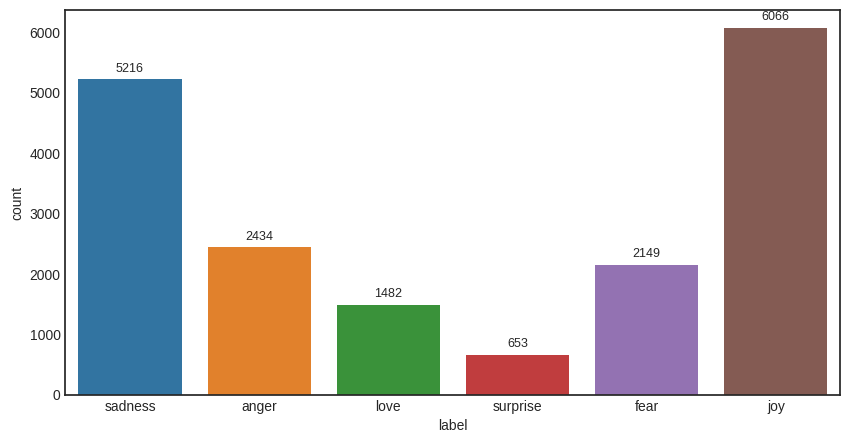

In [10]:
ax=sns.countplot(df.label)
for bar in ax.patches:
    ax.annotate(format(bar.get_height()),
                       (bar.get_x() + bar.get_width() / 2,
                        bar.get_height()), ha='center', va='center',
                       size=9, xytext=(0, 8),
                       textcoords='offset points')

#### But, for the sake of the simplicity, we will merge these labels into two classes, i.e. Positive or Negative sentiment.

1. Positive Sentiment - "joy","love","surprise"
2. Negative Sentiment - "anger","sadness","fear"

In [11]:
def custom_encoder(df):
    df.replace(to_replace ="surprise", value =1, inplace=True)
    df.replace(to_replace ="love", value =1, inplace=True)
    df.replace(to_replace ="joy", value =1, inplace=True)
    df.replace(to_replace ="fear", value =0, inplace=True)
    df.replace(to_replace ="anger", value =0, inplace=True)
    df.replace(to_replace ="sadness", value =0, inplace=True)

In [12]:
custom_encoder(df['label'])

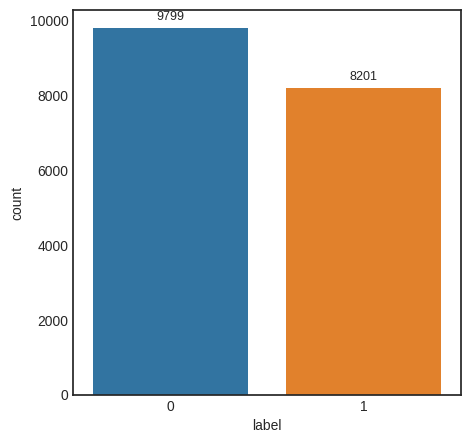

In [54]:
rcParams['figure.figsize'] = 5,5
ax=sns.countplot(df.label)
for bar in ax.patches:
    ax.annotate(format(bar.get_height()),
                       (bar.get_x() + bar.get_width() / 2,
                        bar.get_height()), ha='center', va='center',
                       size=9, xytext=(0, 8),
                       textcoords='offset points')

In [14]:
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,0
3,i am ever feeling nostalgic about the fireplac...,1
4,i am feeling grouchy,0


#### We will create a function for pre-processing of data
1. First, we will iterate through each record and using regualr expression, we will get rid of any characters apart from alphabets.
2. Then, we will convert the string to lowercase as, the word "Good" is different from the word "good". This will cause an issue, when we will create vectors of these words, as two different vectors will be created for the same word which we don't want to.
3. Then we will check for stopwords in the data and get rid of them. Stopwords are commonly used words in a sentence such as "the","an","to" etc. which do not add much value.
4. Then, we will perform lemmatization on each word,i.e. change the different forms of word into a single item called as lemma. A lemma is a base form of a word. For example, run, running and runs are all forms of same lexeme where run is the lemma. Hence, we are converting all occurrences of same lexeme to it's respective lemma.
5. And, then return a corpus of processed data

In [15]:
lm = WordNetLemmatizer()

In [16]:
def text_transformation(df_col):
    corpus = []
    for item in df_col:
        new_item = re.sub('[^a-zA-Z]',' ',str(item))
        new_item = new_item.lower()
        new_item = new_item.split()
        new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus

In [17]:
corpus = text_transformation(df['text'])

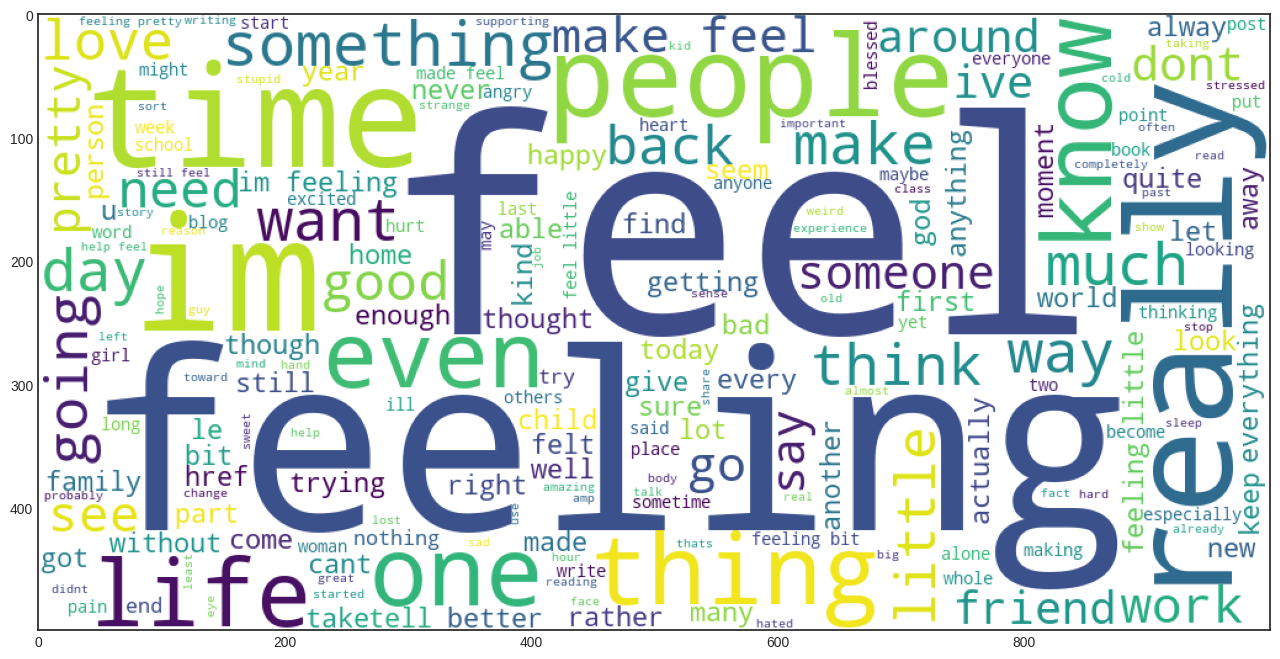

In [18]:
rcParams['figure.figsize'] = 20,8
word_cloud = ""
for row in corpus:
    for word in row:
        word_cloud+=" ".join(word)

wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud)

In [19]:
cv = CountVectorizer(ngram_range=(1,2))
traindata = cv.fit_transform(corpus)

In [20]:
X = traindata
y = df.label

### Random Forest

In [25]:
rf = RandomForestClassifier()
accuracies = cross_val_score(rf, X, y, cv=5)
rf.fit(X,y)

print("Train Score:",np.mean(accuracies))

Train Score: 0.9543888888888888


In [28]:
test_df = pd.read_csv('test.txt',delimiter=';',names=['text','label'])

### Test Data Transformation

In [30]:
X_test,y_test = test_df.text,test_df.label

#encode the labels into two classes , 0 and 1
test_df = custom_encoder(y_test)

#pre-processing of text
test_corpus = text_transformation(X_test)

#convert text data into vectors
testdata = cv.transform(test_corpus)

In [33]:
#predict the target
predictions = rf.predict(testdata)

In [43]:
acc_score = accuracy_score(y_test,predictions)
pre_score = precision_score(y_test,predictions)
rec_score = recall_score(y_test,predictions)

print('Accuracy_score: ',acc_score)
print('Precision_score: ',pre_score)
print('Recall_score: ',rec_score)
print('-------------------------------------------------------------------')
cr = classification_report(y_test,predictions)
print(cr)

Accuracy_score:  0.9585
Precision_score:  0.9583789704271632
Recall_score:  0.9510869565217391
-------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1080
           1       0.96      0.95      0.95       920

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



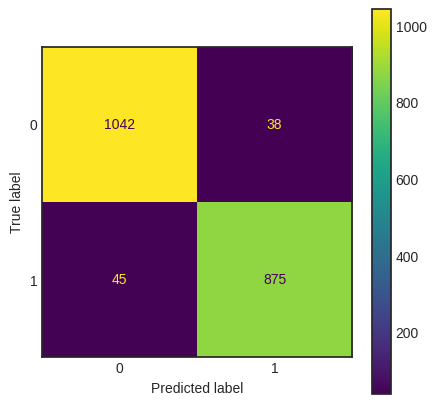

In [45]:
rcParams['figure.figsize'] = 5,5

cm = confusion_matrix(y_test, predictions, labels=rf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf.classes_)
disp.plot()

In [47]:
predictions_probability = rf.predict_proba(testdata)

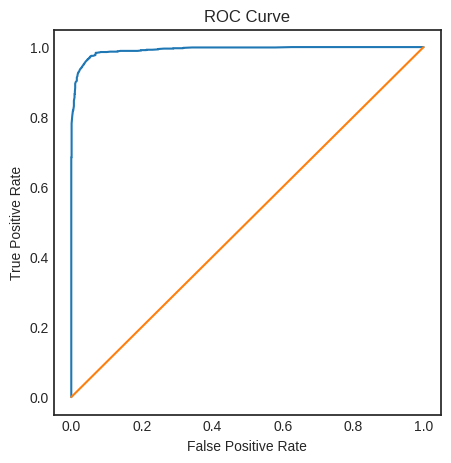

In [48]:
fpr,tpr,thresholds = roc_curve(y_test,predictions_probability[:,1])
plt.plot(fpr,tpr)
plt.plot([0,1])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### Predict for customer input

In [49]:
def expression_check(prediction_input):
    if prediction_input == 0:
        print("Input statement has Negative Sentiment.")
    elif prediction_input == 1:
        print("Input statement has Positive Sentiment.")
    else:
        print("Invalid Statement.")

In [52]:
def sentiment_predictor(input):
    input = text_transformation(input)
    transformed_input = cv.transform(input)
    prediction = rf.predict(transformed_input)
    expression_check(prediction)

In [53]:
input1 = ["Sometimes I just want to punch someone in the face."]
input2 = ["I bought a new phone and it's so good."]


sentiment_predictor(input1)
sentiment_predictor(input2)

Input statement has Negative Sentiment.
Input statement has Positive Sentiment.
